## Influential people's tweets 

The idea of this part of project is to explore how influential people (politicians, journalists, singers, actors, etc.) from different countries used Twitter during the coronavirus pandemic. This task is meant to show how covid actually affected communication on a semantic level, by promoting hashtags and usage of certain words. For the begining, we decide to focus on our homelands countries to have better understanding of each tweets.

In [1]:
import pandas as pd
import numpy as np

import re
import json
import string
from datetime import datetime, timedelta

import translators as ts

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Twitter library
import tweepy

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing hbbelper functions
from helpers import *

Using state Vaud server backend.


<br/>
We are using intervention data (from the given dataset coronawiki) in order to define periods of interest to analyse tweets for each country.

In [2]:
# Importing intervention dates for each country
data_path = './data/'

interventions = pd.read_csv(data_path + 'interventions.csv', delimiter=',', 
                            parse_dates=['1st case', '1st death', 'School closure',
                                         'Public events banned', 'Lockdown', 'Mobility', 'Normalcy'])

interventions.set_index('lang', inplace=True)
interventions.head()

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29


We are loading dataset which provides us with dates and the number of clicks on wikipedia pages (from mobile phones and computers) of different topics during pandemic.

In [3]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path+'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)
    
pagelogs_time_series.keys()

dict_keys(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no', 'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m', 'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'])

<br/>
We are starting our analysis by defining lists containing the names of the analysed countries and the spoken languages in those contries. We will focus on Europian countires from the given dataset.

In [4]:
# List of countires and langugeges spoken in this countries
countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB', 'CA', 'KO', 'JA']
languages = ['fr','da','de','it','nl','no','sv','sr','fi','en', 'ca', 'ko', 'ja']

<br/>
For the first stage, we will focus on retrieving tweets of influential people from Serbia and Italy (our homelands) for the easier verification of the results.

In [5]:
# List of Twitter accounts of influental people from different countries
serbian_influential_people = ['avucic', 'SerbianPM', 'DraganDjilas', 'MarinikaTepic', 'JugoslavCosic',
                              'futomaki', 'VladoGeorgiev', 'brankica_st', 'OAmidzic']

italian_influential_people = ['matteorenzi', 'matteosalvinimi', 'GiorgiaMeloni', 'GiuseppeConteIT',
                              'Corriere', 'SkyTG24', 'LauraPausini', 'ValeYellow46', 'lorenzojova', 'Pontifex_it']

In [6]:
# reading bearer tokens which we need to access Twitter API
with open(data_path+'BearerTokens.json','r') as file:
    bearer_tokens = json.load(file)

In [7]:
def getTwitterUsers(client, usernames):
    """
    Function which retrieving users from 
    Twitter based on usernames
    
    Arguments:
        client : Twitter API v2 Client
        usernames : list of account usernames
    
    Returns:
        users: list of users - id, name, username
    """
    
    users = []
    for username in usernames:
        users.append(client.get_user(username=username))
    return users

In [8]:
# defining client which enables connection with Twitter API
client = tweepy.Client(bearer_token=bearer_tokens["maja"], wait_on_rate_limit=True)

# getting users accounts from twitter
serbian_users = getTwitterUsers(client, serbian_influential_people)
italian_users = getTwitterUsers(client, italian_influential_people)

for user in serbian_users: print(user.data.id, user.data.name, user.data.username)

356450858 Александар Вучић avucic
3036495555 Aна Брнабић SerbianPM
205153283 Dragan Djilas DraganDjilas
834073582514888710 Marinika Tepić MarinikaTepic
2814717661 Jugoslav Ćosić JugoslavCosic
181338564 Marija Serifovic futomaki
41577631 Vlado Georgiev - Barba VladoGeorgiev
1087237020 Brankica Stankovic brankica_st
324198256 ognjen amidzic OAmidzic


<br/>
We want to retrieve tweets from different periods during pandemic, but mostly focusing on weeks preceding intervention days or period with peeks in number of new cases and people's deaths. As an example, we are starting with period three weeks before lockdown in each country.

In [9]:
# Defining period of interest for each country. Dates refered to 3 weeks before the first lockdown
lockdown_dates =  [interventions.loc[lang, 'Lockdown'] if not pd.isnull(interventions.loc[lang,'Lockdown']) else 
                  interventions.loc[lang,'Mobility'] for lang in languages]

period_per_countries = {}
for idx,country in enumerate(countries):
    lang = languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates
    
# e.g. three weeks before lockdown in Serbia and Italy
print('Serbia',period_per_countries['RS'][0],'-',period_per_countries['RS'][-1])
print('Italy',period_per_countries['IT'][0],'-',period_per_countries['IT'][-1])
print('Germany',period_per_countries['DE'][0],'-',period_per_countries['DE'][-1])
print('Japan',period_per_countries['JA'][0],'-',period_per_countries['JA'][-1])

Serbia 2020-03-01 00:00:00 - 2020-03-20 00:00:00
Italy 2020-02-20 00:00:00 - 2020-03-10 00:00:00
Germany 2020-03-02 00:00:00 - 2020-03-21 00:00:00
Japan 2020-03-11 00:00:00 - 2020-03-30 00:00:00


<br/>
Now, we want to create dataframe which will contain tweets from influential people from different countries. Each row will contain tweet id, country and languge of tweet, id of user which posted that tweet, orginal text of tweet and its translation to english, date when tweeet is posted and context annotation retrieved from Twitter API.

<br/>
Let's load our dataset with tweets.

In [10]:
# this dataframe is created by calling function 'getTweets' from helpers.py
influential_people_tweets = pd.read_csv('./output/influential_people_tweets.csv')
influential_people_tweets.head()

,id,country_code,lang,user,tweet_text_orginal,tweet_text_en,tweet_date,context_annotations
0,1234249601517047814,RS,sr,Response(data=<User id=356450858 name=Александ...,Хвала @AIPAC на изузетној части да говорим на ...,thanks on an exceptional honor to speak at the...,2020-03-01 22:50:10+00:00,"[{'domain': {'id': '45', 'name': 'Brand Vertic..."
1,1234183480625553410,RS,sr,Response(data=<User id=205153283 name=Dragan D...,"Ovakvih snimaka, kao ni onih kada ih izbacuju ...",several recordings like no ones when they thro...,2020-03-01 18:27:26+00:00,[]
2,1234196504123969536,RS,sr,Response(data=<User id=834073582514888710 name...,"Da li stel primetili suptilnu, ali vrlo podmuk...",did stel noticed a subtle but very insidious s...,2020-03-01 19:19:11+00:00,[]
3,1234253894244536323,RS,sr,Response(data=<User id=181338564 name=Marija S...,Safe trip girls🎉 #Hurricane,safe trip girls #hurricane,2020-03-01 23:07:14+00:00,[]
4,1234252303810600961,RS,sr,Response(data=<User id=181338564 name=Marija S...,Jebote jel su ljudi zaboravili da se raduju ????,fuck did people forget that they are looking f...,2020-03-01 23:00:55+00:00,[]


In [11]:
influential_people_tweets.shape

(24607, 8)

<br/>
For each country we would like to recognise to which topics tweets are related, what are most common used words in tweets and to check sentyment of the tweets. All of this can be useful to understand the way communication has changed during the pandemic and impacted people.


In [12]:
# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()


After reading the categories offered by empath library at https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use.

In [33]:
topics = ['help', 'medical_emergency', 'health', 'government', 'school', 'kill', 'art', 'play', 'computer',
         'home', 'business', 'religion', 'sports', 'military', 'music', 'science', 'fun', 'economics',
         'technology', 'philosophy', 'geography', 'tv', 'architecture']

emotions = ["suffering", "optimism", "fear", "sadness", "joy", "anger", "pain", "negative_emotion", 
            "positive_emotion", "happiness"]

Using Empath library we want to check to which topics tweets from period three weeks before lockdown are mostly related. We will plot result to two countries, Serbia and Italy.

In [34]:
# function for plotting topic discussed in tweets
def plotTweetsTopics(country_code, country_name, topics, influential_people_tweets):
    """
    Function which plots topic discussed in tweets
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        topics: list of topics
        influential_people_tweets: dataframe with tweets
    """
    
    # We infer the topics discussed in the retrieved tweets
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
     # plot only if we have some data from country
    if len(tweets_from_country) > 0:
        classified_topics = pd.DataFrame([lexicon.analyze(tweets_from_country.str.cat(sep=' '),
                                                      categories=topics, 
                                                      normalize=True)], index=[country_code]).T

        classified_topics = classified_topics.sort_values(by=[country_code], ascending=False)
        classified_topics.reset_index(inplace=True)
        
        fig,ax = plt.subplots(1, figsize=(6,6))

        sns.barplot(data=classified_topics, x=country_code, y='index')

        plt.xlabel('Normalized Score')
        plt.ylabel('Topics', fontsize=14)
        plt.title('Topics discussed in ' + country_name + ' during the 3 weeks preceding the official lockdown')
        plt.show()

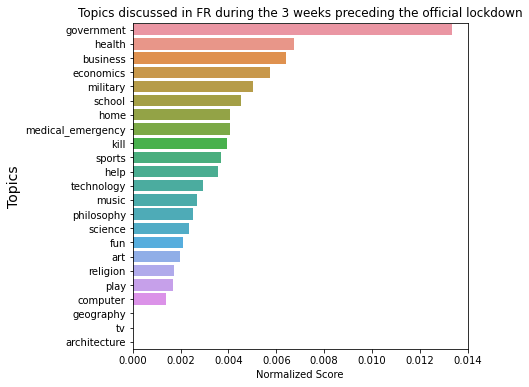

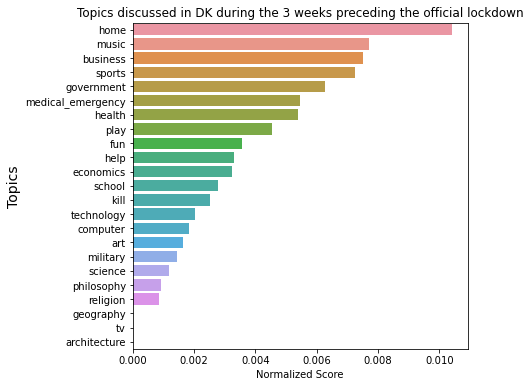

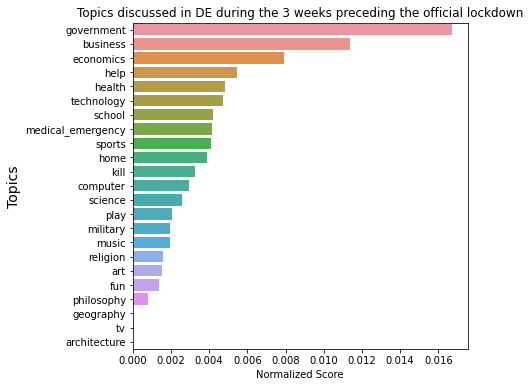

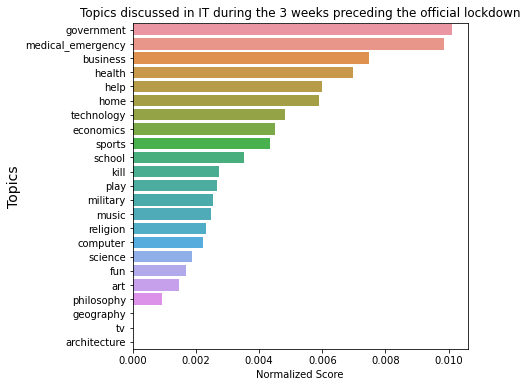

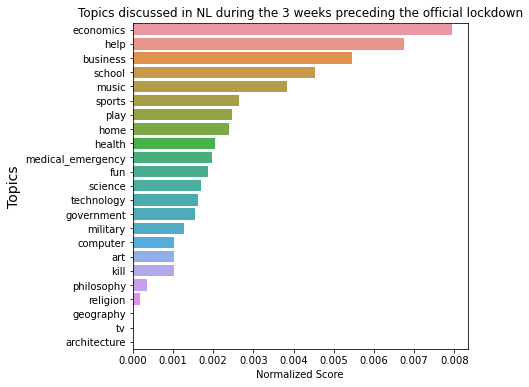

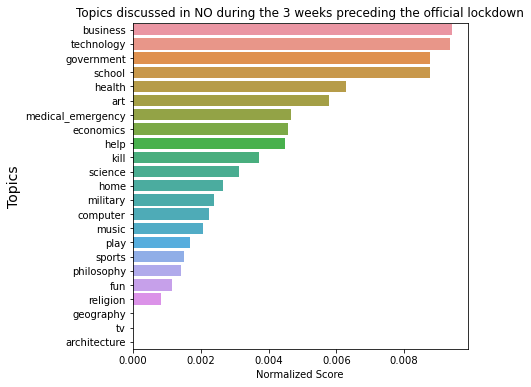

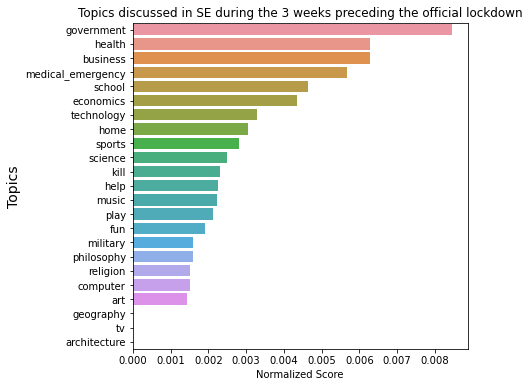

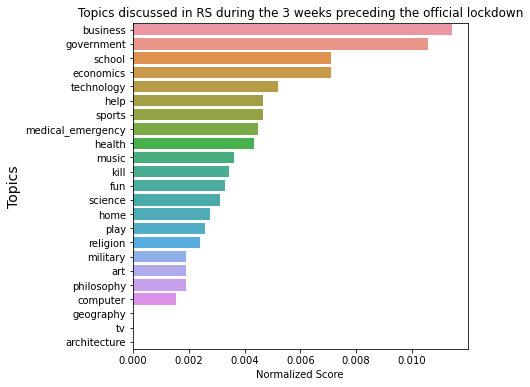

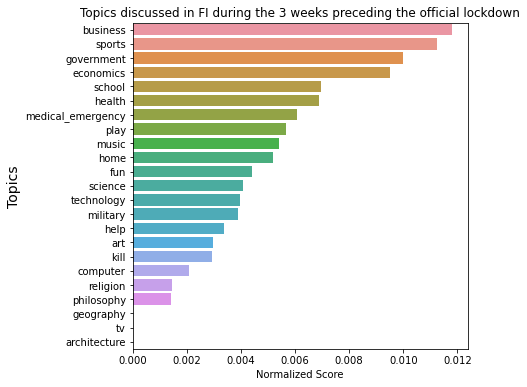

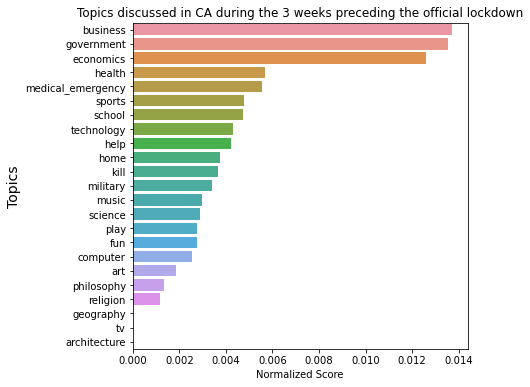

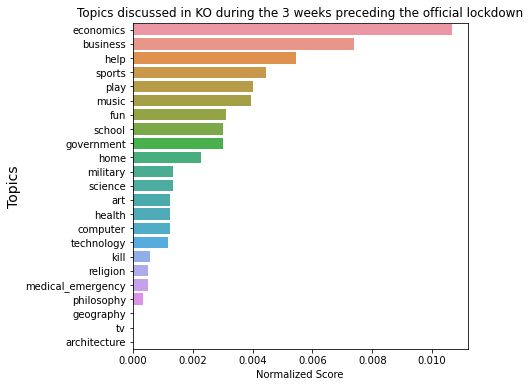

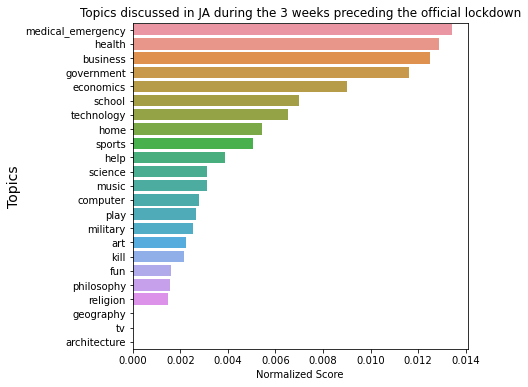

In [36]:
# plotting topic discussed in Serbia and Italy 3 weeks precedign the lockdown
#plotTweetsTopics('RS', 'Serbia', topics, influential_people_tweets)

for country in countries:
    plotTweetsTopics(country, country, topics, influential_people_tweets)

Using Empath library we want to check to which topics tweets from period three weeks before lockdown are mostly related. We will plot result to two countries, Serbia and Italy.

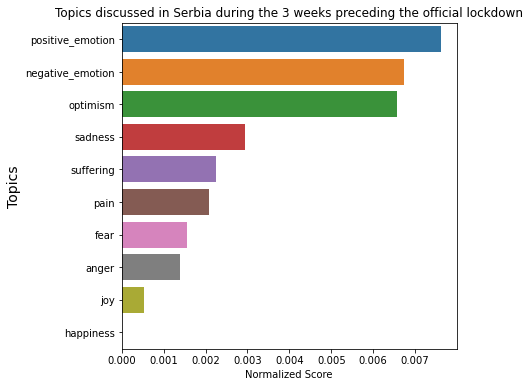

In [37]:
# Plotting dominating emotions in tweets in Serbia and Italy 3 weeks precedign the lockdown
plotTweetsTopics('RS', 'Serbia', emotions, influential_people_tweets)

As next step in our analysis, we want to find most used words in tweets in different countries. As an example we are plotting most used words in tweets of Serbian and Italian influencing Twitter users.

In [38]:
from collections import Counter

def plotMostCommonWords(country_code, country_name, influential_people_tweets):
    """
    Function which plot most common words in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_words: list of most common words in tweeets
        all_words: all words from the tweets
    """
    
    # spliting text on words removing stop words, and looking only to nouns and verbs
    lemmatizer = WordNetLemmatizer()
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
    all_words = ("".join(tweets_from_country.str.cat(sep=' '))).split()
    all_words = [lemmatizer.lemmatize(term) for term in all_words 
                 if (term not in stopwords.words('english')) and 
                 (nltk.pos_tag([term])[0][1] == 'NN' or nltk.pos_tag([term])[0][1] == 'VB')]

    # ten most common words
    most_common_words = Counter(all_words).most_common(10)

    words = list(dict(most_common_words).keys())
    counts = list(dict(most_common_words).values())

    plt.xlabel('Most used words', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=90)
    plt.title('Most used words in influencing people tweets from '+ country_name)
    plt.bar(range(len(words)), counts, tick_label=words)
    plt.show()
    
    return most_common_words, all_words

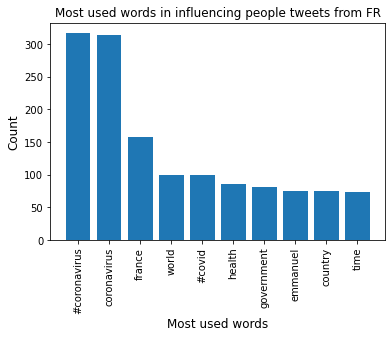

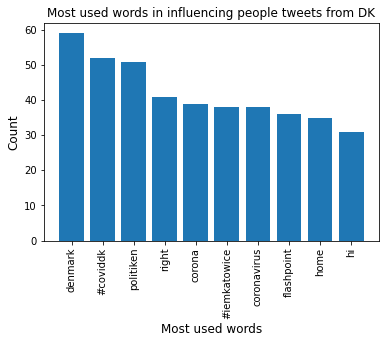

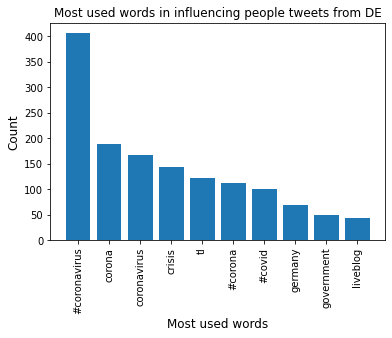

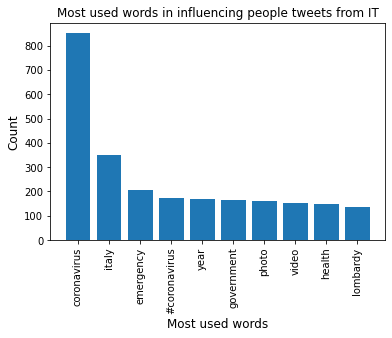

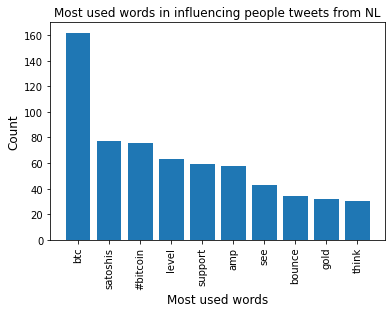

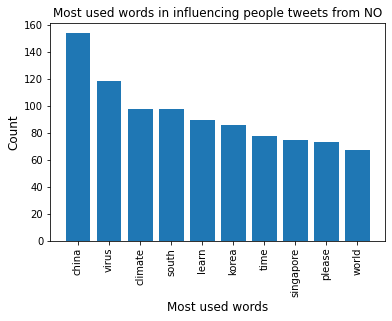

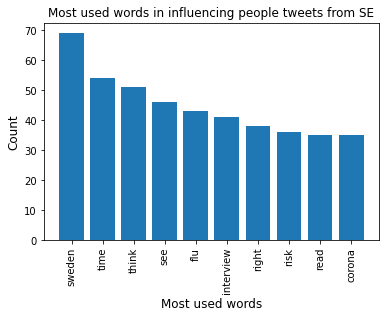

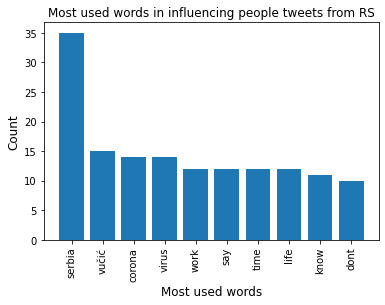

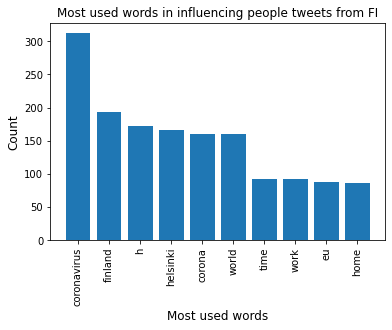

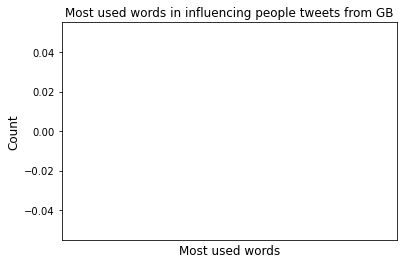

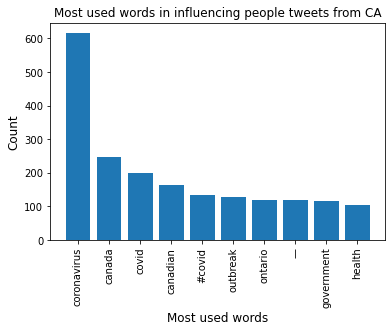

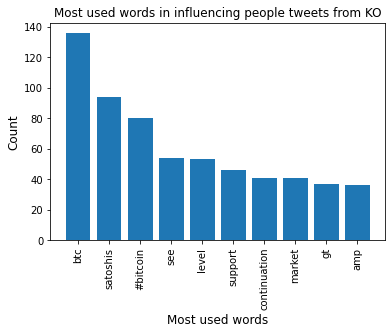

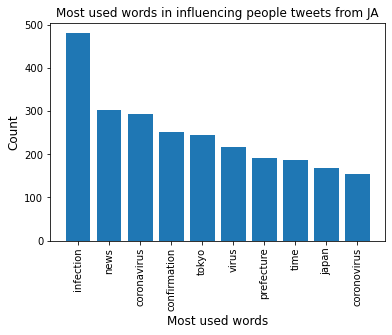

In [40]:
# plotting most common words in Serbian and Italian tweets
most_common_words = {}
all_words = {}
for country in countries:
    most_common, words = plotMostCommonWords(country, country, influential_people_tweets)
    most_common_words[country] = most_common
    all_words[country] = words

Similarly, let us find most used hashtags in tweets in different countries. As an example we are plotting most used hashtags in tweets of Serbian and Italian influencing Twitter users.

In [41]:
def plotMostCommonHashtags(country_name, all_words):
    """
    Function which plot most common hashtags in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_hashtags: list of most common words in tweeets
    """
    #finding most common hashtags
    hashtags = [word for word in all_words if ('#' in word)]
    most_common_hashtags = Counter(hashtags).most_common(10)

    hashtags = list(dict(most_common_hashtags).keys())
    counts = list(dict(most_common_hashtags).values())

    plt.xlabel('Most used hashtags', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=90)
    plt.title('Most used hashtags in influencing people tweets from ' + country_name)
    plt.bar(range(len(hashtags)), counts, tick_label=hashtags)
    plt.show()
    
    return most_common_hashtags

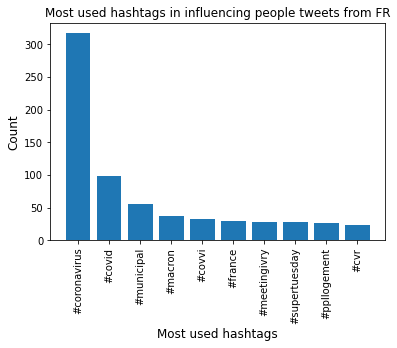

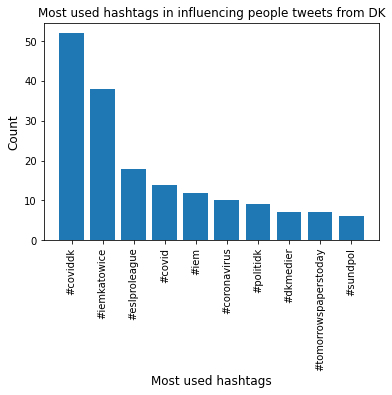

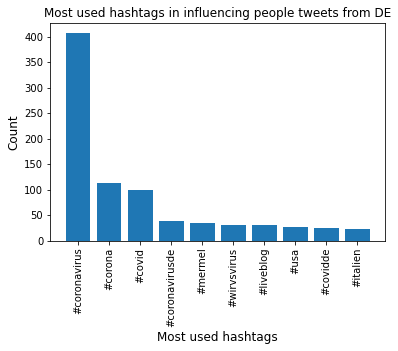

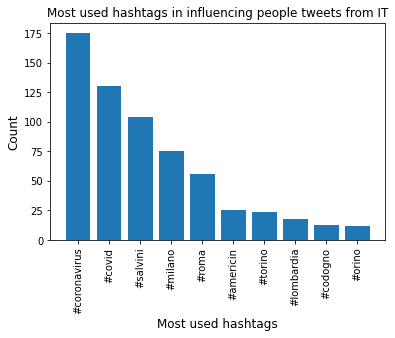

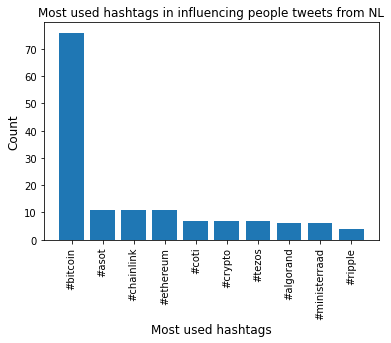

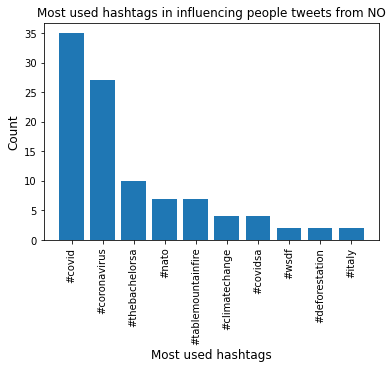

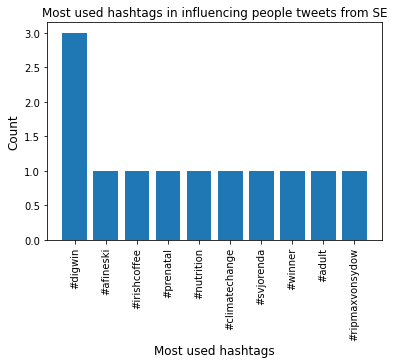

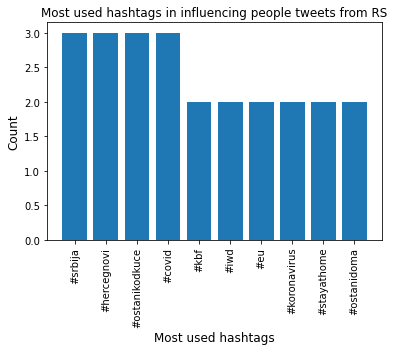

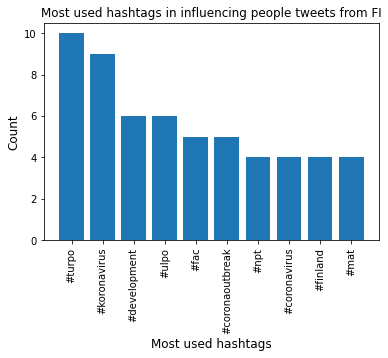

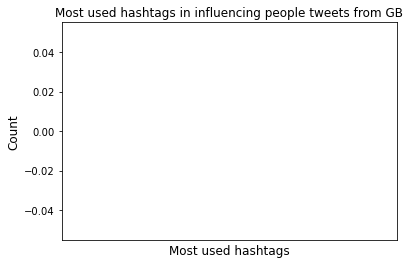

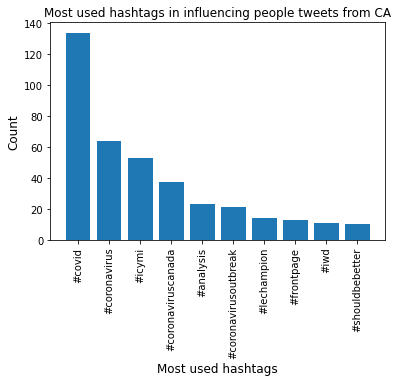

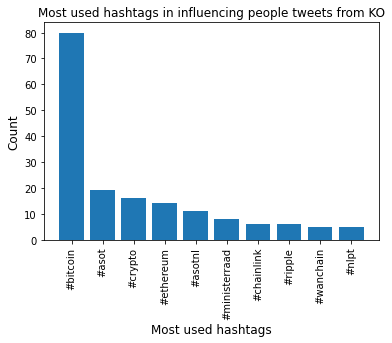

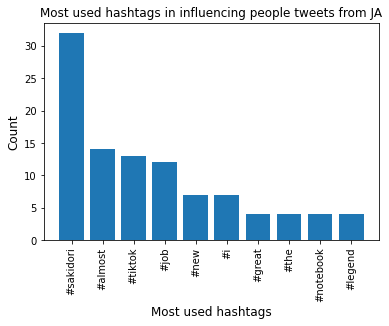

In [42]:
# plotting most common hashtags in Serbia and Italy
most_common_hashtags = {}
for country in countries:
    hashtags = plotMostCommonHashtags(country, all_words[country])
    most_common_hashtags[country] = hashtags

Since hashtags are sometime composed from multiple words, and it is difficult to translate it using some libraries, we are doing it manually and plotting again. Again, we are doing this for Serbia and Italy as an example. 

In [45]:
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

def imgHashtags(hashtags):
    """
    Function which shows most common hashtags 
    
    Arguments:
        hashtags: dict of hashtags
    """
    wc = WordCloud(background_color='white').generate_from_frequencies(dict(hashtags))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

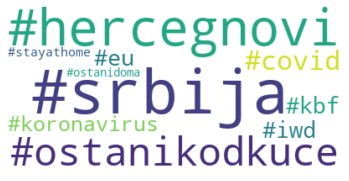

In [47]:
# show most common hashtags in Serbia in english
most_common_hashtags_RS = { '#serbia': 3, '#stayathome': 7, '#covid': 3, 
                           '#hercegnovi': 3, '#coronavirus': 2, '#eu': 2,
                           '#iwd': 2, '#kbf': 2 }

imgHashtags(most_common_hashtags['RS'])

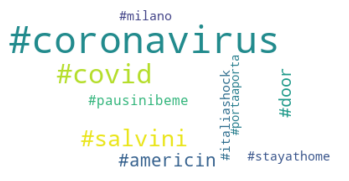

In [48]:
# show most common hashtags in Italy in english
most_common_hashtags_IT = {'#coronavirus': 70, '#covid': 30, '#salvini': 20,
 '#americin': 11, '#door': 10,'#pausinibeme': 6, '#italiashock': 5,
 '#stayathome': 5, '#milano': 5, '#portaaporta': 4}

imgHashtags(most_common_hashtags_IT)

As last step in initial analysis of tweets of influencing people from different countries, we are defining function which calculate tweet sentiment to give us more infomarion about tweets in one coutry. Even if we are not going to use it now, we define these helpers function that might help us n task 3.

In [49]:
# sentiment analysis using TextBlob
from textblob import TextBlob 

def tweetSentiment(data):
    text_sentiment = TextBlob(data).sentiment
    return text_sentiment.polarity, text_sentiment.subjectivity

In [50]:
for index, row in influential_people_tweets.iterrows():
    tweet = str(row['tweet_text_en'])
    polarity, subjectivity = tweetSentiment(tweet)   
    print(tweet, "==>", polarity, "-" ,subjectivity)
    break

thanks on an exceptional honor to speak at the conference we are proud of the historical friendship with the jewish people we love jews and we will work on further improving our relationships #srbija #atrael ==> 0.3095238095238096 - 0.4714285714285715


#### LDA (Latent Dirichlet Allocation) - topic modeling

We want to use LDA in order to quantify how much covid realted tweets are important in different countries. By using LDA we try reconstruct the topic model(bag of words) that might have generated the tweets we retreived. 

In [55]:
# Topic analysis libraries
import spacy
import pyLDAvis 
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models as gensimvi

import gensim
from gensim import corpora

/Users/skocko/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Now, we will define helper function used by 'createLDAModel' function in order to create tokens starting from text data.

In [56]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    # Initialize spaCy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# constructing pair of words
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

# constructing set of three words
def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [57]:
# function for creating LDA model
def createLDAModel(influential_people_tweets, country_code, number_topics):
    """
    Function which creates LDA model 
    
    Arguments:
        influential_people_tweets: dataset which contains tweets from influential people
        country_code: country for which we are creating model 
        number_topics: number of topics 
    """
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                            'tweet_text_en']

    data_words = []
    for row in tweets_from_country:
        data_words.append(str(row).split())

    #print("Words example\n", data_words[:1])

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    #print("\nTrigram example\n", trigram_mod[bigram_mod[data_words[0]]])

    data_words_bigrams = make_bigrams(data_words, bigram_mod)

    # Perform lemmatization keeping noun, adjective, verb, and adverb
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) #, 'ADJ', 'VERB', 'ADV'

    #print("\nData lemmatization\n", data_lemmatized[:1])

    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Create a LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=number_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=5,
                                               passes=10,
                                               alpha='auto',
                                               eval_every=5, 
                                               per_word_topics=True)

    doc_lda = lda_model[corpus]

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    pyLDAvis.enable_notebook()
    visualization = gensimvi.prepare(lda_model, corpus, id2word)
    return visualization

In [60]:
visualization = createLDAModel(influential_people_tweets, 'IT', 6)
visualization


Perplexity:  -9.87905021033035


/Users/skocko/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/skocko/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/skocko/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/skocko/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/skocko/opt/anaconda3/lib/python3.9/site-packages/past/builtins/mi

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.211711  0.018934       1        1  26.973225
1     -0.017390  0.011408       2        1  19.847563
2     -0.025725 -0.176607       3        1  19.833075
3     -0.058331  0.065919       4        1  13.765007
5     -0.048894  0.033869       5        1  11.042980
0     -0.061371  0.046476       6        1   8.538149, topic_info=           Term        Freq       Total Category  logprob  loglift
166           #  335.000000  335.000000  Default  30.0000  30.0000
27        today  267.000000  267.000000  Default  29.0000  29.0000
866     measure  237.000000  237.000000  Default  28.0000  28.0000
711   emergency  269.000000  269.000000  Default  27.0000  27.0000
691       virus  151.000000  151.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
92     prisoner    5.247740   95.471542   Topic6  -5.7471  -0.4404
91       prison    5.156273  104.926997   Topic6  -5.7646  -0.5524
958   lombardia    5.150319  125.272622   Topic6  -5.7658  -0.7308
732      market    4.059365   72.436104   Topic6  -6.0038  -0.4211
3415     revolt    3.932564   60.360909   Topic6  -6.0356  -0.2704

[315 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
166       3  0.996579         #
469       3  0.943467  accident
1419      1  0.563466  activity
1419      2  0.207593  activity
1419      3  0.148281  activity
...     ...       ...       ...
410       3  0.991537    worker
463       2  0.986757     world
39        3  0.994482      year
413       6  0.972179  year_old
302       4  0.965218         »

[579 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 6, 1])

#### Conclusion & future steps

From the subset of data we retrieved so far, we can conclude that in both countries influencial people started to spread a word about covid, and to warn population to #stayathome. 

We are planning to use output of LDA model to compute attention score in the next task, and it will be explained better in that part.  

In [14]:
# Task 2 functions
import time

def remove_emojis(data):
    """
    Function which removing emojis from tweet's text
    
    Arguments:
        data : tweet text
    
    Returns:
        text: text without emojis
    """
    
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
    

def update_influental_people_dataframe(client, country_code, lang, users, dates, influential_people_tweets):
    """
    Function which retrieving new tweets using Twitter API
    
    Arguments:
        client : Twitter API v2 Client
        country_code: country from which we are retrieving tweets
        lang: languge of tweets we are retrieving
        users: list of users which tweets we want to retrieve
        dates: list of dates for which we want to retrieve tweets
        influential_people_tweets: dataframe which will contain new tweets
    
    Returns:
        influential_people_tweets: dataframe containing tweets which 
        satisfying conditions sent as parameters of function
    """
        
    limit_counter = 0 
        
    for ix, day in enumerate(dates[country_code]):
        
        # For each day get tweets for each user from country_code (max 100 tweets per day)
        
        start_time = dates[country_code][ix]
        end_time =  start_time + timedelta(days=1)
    
        for user in users:
            # We define a proper query to get tweets from the country we're interested in
            query = "from:{} -is:retweet".format(user.data.id)

            tweets = client.search_all_tweets(query, max_results=100, 
                                          start_time=start_time, end_time=end_time,
                                          tweet_fields=['id','text','context_annotations','created_at'])
            
            time.sleep(1)
            limit_counter += 1
            if(limit_counter == 290): # just in case a bit less than 300
                limit_counter = 0
                sleep_time = 60 * 15 + 30
                time.sleep(sleep_time) # sleep for 15minutes + 30s just in case

            if(tweets.data == None): continue

            for tweet in tweets.data: 
                tweet_en = tweet.text

                #translating tweet to english
                if lang != 'en':
                    try:
                        tweet_en = ts.google(tweet.text)
                    except:
                        tweet_en = None

                if tweet_en != None:
                    # removing punctuation
                    tweet_en = ("".join([ch for ch in tweet_en if ch not in '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'])).lower()
                    tweet_en.strip()
                    # removing numbers
                    tweet_en = re.sub("\d+", "", tweet_en).strip()

                    # merging hashtag sign with next word 
                    if('# ' in tweet_en):
                        tweet_en.replace('# ', '#')

                    # removing emojis
                    tweet_en = remove_emojis(tweet_en)

                    # removing username tags and http links
                    if('http' in tweet_en) or ('@' in tweet_en):
                        tweet_en = " ".join(filter(lambda word: (not word.startswith('http')) and (not word.startswith('@')),
                                                   tweet_en.split()))

                new_tweet = pd.DataFrame([{'id': tweet.id, 'country_code': country_code, 'lang': lang, 'user': user,
                                           'tweet_text_orginal': tweet.text, 'tweet_text_en': tweet_en, 
                                           'tweet_date': tweet.created_at,
                                           'context_annotations': tweet.context_annotations }])

                influential_people_tweets = pd.concat([influential_people_tweets, new_tweet], axis=0, ignore_index=True)
        
    
    influential_people_tweets.to_csv('./output/influential_people_tweets_' + country_code + '.csv', index=False)
    return influential_people_tweets



def getTweets(client, country, lang, users, periods):
    # retrieving tweets (delete the dot from line below to execute)
    influential_people_tweets = pd.read_csv('./output/influential_people_tweets.csv', delimiter=',')
    influential_people_tweets_update = pd.DataFrame(columns=['id','country_code', 
                                                             'lang', 'user',
                                                             'tweet_text_orginal', 'tweet_text_en', 
                                                             'tweet_date', 'context_annotations'])

    influential_people_tweets_update = update_influental_people_dataframe(client, country, lang, 
                                                                          users,  periods, 
                                                                          influential_people_tweets_update)

    # concat new tweets with pervious one
    influential_people_tweets = pd.concat([influential_people_tweets, influential_people_tweets_update], ignore_index=True)
    influential_people_tweets.to_csv('./output/influential_people_tweets.csv', index=False)
    

In [26]:
norway_influential_people = ['jensstoltenberg', 'MagnusCarlsen', 'erna_solberg', 'KygoMusic', 'tveitdal', 
                            '_girlinred_', 'ErikSolheim', 'jonasgahrstore', 'SteinarSagen',
                             'zilevandamme', 'martinio98']

denmark_influential_people = ['rafvdvaart', 'Bjergsen', 'dev1ce', 'karriganCSGO', 'dupreeh', 
                              'AndersFoghR', 'MOMOMOYOUTH', 'larsloekke', 'lasserimmer',
                              'Deficiolol', 'AmbMellbin', 'hltvorg', 'politiken', 'rigspoliti']

france_influential_people = ['davidguetta', 'kmbappe', 'emmanuelmacron', 'mlp_officiel', 'jlmelenchon', 
                              'debbouzejamel', 'fhollande', 'lemondefr', 'france24_fr', 'elysee']

germany_influential_people = ['bschweinsteiger', 'esmuellert_', 'tagesschau', 'janboehm', 'regsprechersts', 
                              'c_lindner', 'abaerbock', 'olafscholz', 'swagenknecht', 'officiallyjoko']

canada_influential_people = ['theweeknd', 'cbcnews', 'globeandmail', 'rickmercer', 'stephenharper', 
                              'jackphan', 'nationalpost', 'fordnation', 'norm', 'iamjericho']

netherlands_influential_people = ['Persie_Official', 'Kuyt', 'vdsar1970', 'arminvanbuuren', 'minpres', 
                                  'R3HAB', 'CryptoMichNL', 'APechtold', 'eenjurk', 'raphaelmaitimo',
                                  'SigridKaag']

sweden_influential_people = ['hanifbali', 'jimmieakesson', 'JohanForssell', 'pwolodarski',
                             'fribergCS', 'Ivarpi', 'glasklart', 'margotwallstrom', 
                             'niklassvensson', 'BjornLomborg']

korea_influential_people = ['siwonchoi', 'krungy21', 'shfly3424', 'TheBlueHouseENG', 'President_KR', 
                            'special1004', 'donghae861015', 'kita_net', 'MOFAkr_eng', 'Seoul_gov']

finland_influential_people = ['chachigonzales', 'alexstubb', 'niinisto', 'yleuutiset', 'hsfi', 
                              'haavisto', 'h_kovalainen', 'tarjahalonen', 'ulkoministerio', 'faze_kitty']

japan_influential_people = ['ariyoshihiroiki', 'nhk_news', 'hashimoto_lo', 'itoi_shigesato', 'yutonagatomo5',
                            'kenichiromogi', 'tsuda', 'hiroyoshimura', 'the_darenogare', 'inosenaoki']

In [16]:
# 300 requests / 15 minutes, per app; 1 request per user per 1s
client = tweepy.Client(bearer_token=bearer_tokens["balsa"], wait_on_rate_limit=False)

In [ ]:
getTweets(client, 'RS', 'sr', serbian_users, period_per_countries)
getTweets(client, 'IT', 'it', italian_users, period_per_countries)

In [13]:
# Norway
norway_users = getTwitterUsers(client, norway_influential_people)
getTweets(client, 'NO', 'no', norway_users, period_per_countries)  

In [16]:
# Denmark
denmark_users = getTwitterUsers(client, denmark_influential_people)
getTweets(client, 'DK', 'da', denmark_users, period_per_countries)  

In [18]:
# France
france_users = getTwitterUsers(client, france_influential_people)
getTweets(client, 'FR', 'fr', france_users, period_per_countries) 

In [14]:
# Germany
germany_users = getTwitterUsers(client, germany_influential_people)
getTweets(client, 'DE', 'de', germany_users, period_per_countries)

In [14]:
# Canada
canada_users = getTwitterUsers(client, canada_influential_people)
getTweets(client, 'CA', 'ca', canada_users, period_per_countries) 

No lock down - Netherlands, Sweden, Korea, Finland, Japan

Plot mobility data to find change point for these countries

Update data frame and than find period_per_countries

In [18]:
def checkLockdown(lang, country_name):
    apple_mobility = pd.read_csv('data/applemobilitytrends-2020-04-20.csv.gz', compression="infer")
    mobilityDate = interventions[interventions.index == lang]["Mobility"][0].strftime("%Y-%m-%d")

    df = apple_mobility[(apple_mobility["region"]==country_name)]
    df = df[apple_mobility["transportation_type"]=="walking"]

    values = []
    dates = []
    for i in range(14,1,-1):
        column = (interventions[interventions.index == lang]["Mobility"][0] + 
                  timedelta(days=-i)).strftime("%Y-%m-%d")
        dates.append(column)
        values.append(df[column].iloc[0])

    for i in range(0,14):
        column = (interventions[interventions.index == lang]["Mobility"][0] + 
                  timedelta(days=i)).strftime("%Y-%m-%d")
        dates.append(column)
        values.append(df[column].iloc[0])

    plt.figure(figsize=(7,5))
    plt.plot(dates, values, linestyle = 'dotted')
    plt.axvline(x = mobilityDate, color = 'b', label = 'axvline - full height')
    plt.xticks(rotation=90)
    plt.show()

/var/folders/ny/tg4q5d2s2h3fdx65j_cch7rh0000gn/T/ipykernel_55866/4164317151.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[apple_mobility["transportation_type"]=="walking"]


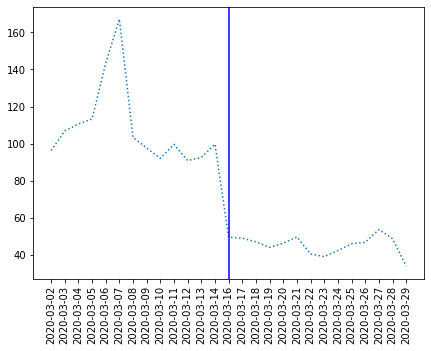

In [156]:
checkLockdown('nl', 'Netherlands')
# checkLockdown('sv', 'Sweden')
# checkLockdown('fi', 'Finland')
# checkLockdown('ja', 'Japan')
# checkLockdown('ko', 'Republic of Korea')

In [27]:
# Netherlands 
netherlands_users = getTwitterUsers(client, netherlands_influential_people)
getTweets(client, 'NL', 'nl', netherlands_users, period_per_countries)  

In [28]:
# Sweden 
sweden_users = getTwitterUsers(client, sweden_influential_people)
getTweets(client, 'SE', 'sv', sweden_users, period_per_countries)  

In [29]:
# Korea
korea_users = getTwitterUsers(client, netherlands_influential_people)
getTweets(client, 'KO', 'ko', korea_users, period_per_countries)  

In [30]:
# Finland
finland_users = getTwitterUsers(client, finland_influential_people)
getTweets(client, 'FI', 'fi', finland_users, period_per_countries)  

In [31]:
# Japan
japan_users = getTwitterUsers(client, japan_influential_people)
getTweets(client, 'JA', 'ja', japan_users, period_per_countries)  

<br/>
<br/>
<br/>
<br/>
